# Generates a graph based on the temporal occurence of each feature

### Initialization:

In [1]:
import numpy as np
import tensorflow.compat.v1 as tf
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn import metrics

tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# File Names
load_pre = '../'
bases_name = 'bases.npy'
alpha_name = 'batch_alpha.npy'

### Auto-correlate Matrix:

In [3]:
# Get filter size
F = np.load(load_pre + bases_name)
k_sz = np.int32(np.floor(np.sqrt(F.shape[1])))

# Load alphas generated by ../csc.py
alpha = np.load(load_pre + alpha_name)
N, H, W, K = alpha.shape;

# Create Correlation Matrix
corr = np.zeros((K, K))

for n in range(N - 1):
    print('# ' + str(n) + '/' + str(N - 2))
    
    A0 = alpha[n].reshape([-1, K]);
    A1 = alpha[n + 1].reshape([-1, K]);

    #A0 = np.sign(A0)
    #A1 = np.sign(A1)
    
    factor1 = np.matmul(A0.transpose(), A1)
    factor2 = np.matmul(A1.transpose(), A0)

    corr += factor1
    corr += factor2

# 0/254
# 1/254
# 2/254
# 3/254
# 4/254
# 5/254
# 6/254
# 7/254
# 8/254
# 9/254
# 10/254
# 11/254
# 12/254
# 13/254
# 14/254
# 15/254
# 16/254
# 17/254
# 18/254
# 19/254
# 20/254
# 21/254
# 22/254
# 23/254
# 24/254
# 25/254
# 26/254
# 27/254
# 28/254
# 29/254
# 30/254
# 31/254
# 32/254
# 33/254
# 34/254
# 35/254
# 36/254
# 37/254
# 38/254
# 39/254
# 40/254
# 41/254
# 42/254
# 43/254
# 44/254
# 45/254
# 46/254
# 47/254
# 48/254
# 49/254
# 50/254
# 51/254
# 52/254
# 53/254
# 54/254
# 55/254
# 56/254
# 57/254
# 58/254
# 59/254
# 60/254
# 61/254
# 62/254
# 63/254
# 64/254
# 65/254
# 66/254
# 67/254
# 68/254
# 69/254
# 70/254
# 71/254
# 72/254
# 73/254
# 74/254
# 75/254
# 76/254
# 77/254
# 78/254
# 79/254
# 80/254
# 81/254
# 82/254
# 83/254
# 84/254
# 85/254
# 86/254
# 87/254
# 88/254
# 89/254
# 90/254
# 91/254
# 92/254
# 93/254
# 94/254
# 95/254
# 96/254
# 97/254
# 98/254
# 99/254
# 100/254
# 101/254
# 102/254
# 103/254
# 104/254
# 105/254
# 106/254
# 107/254
# 108/254
# 109/254
# 110/254


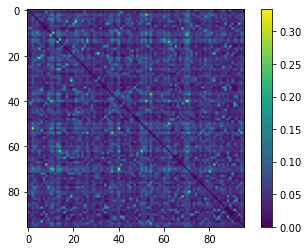

In [4]:
# Correlated matrix
A = corr / np.max(corr)
np.fill_diagonal(A, 0.0)

# Show
plt.imshow(A)
plt.colorbar()
plt.show()

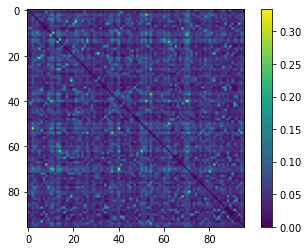

In [5]:
# Thresholded version
threshold = 0.0;
active = np.sign(np.maximum(A - threshold, 0))

A *= active

#A = np.sign(A)
plt.imshow(A)
plt.colorbar()
plt.show()

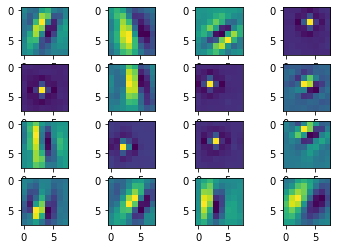

b


In [6]:
# Show Features of A in grid
nn_sqrt = 4;
nn_num = nn_sqrt*nn_sqrt;

for k in range(K):
    edges = A[k];
    
    nn = np.argsort(edges)[-nn_num + 1:]
    
    plt.subplot(nn_sqrt,nn_sqrt,1)
    plt.imshow(F[k,:].reshape([k_sz, k_sz]))
    
    for i in range(nn_num-1):
        plt.subplot(nn_sqrt,nn_sqrt,i+2)
        plt.imshow(F[nn[i], :].reshape([k_sz, k_sz]))
    plt.show()
    if input() == 'b':
        break


### Create Graph

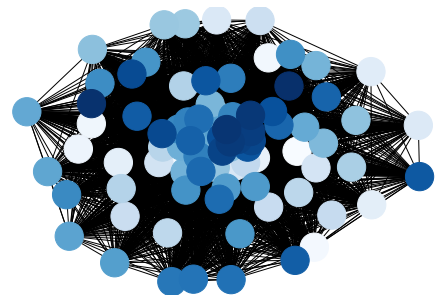

In [7]:
# Draw graph
G = nx.from_numpy_matrix(A)
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, node_color=range(G.number_of_nodes()), node_size=800, cmap=plt.cm.Blues)
plt.show()

### Cluster Graph

In [8]:
# Clustering Parameters
num_clusters = 8
num_kmeans = 100

# Spectral Clustering
sc = SpectralClustering(num_clusters, affinity = "precomputed", n_init = num_kmeans)
sc.fit(A)

SpectralClustering(affinity='precomputed', n_init=100)

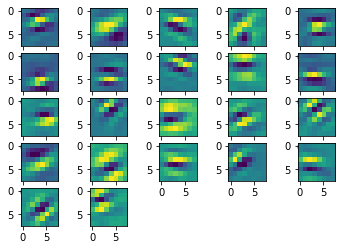

In [10]:
# Visualization Parameters
cluster_num = 1

# Visualization
cluster = np.squeeze(np.argwhere(sc.labels_ == cluster_num))
n_sqrt = np.ceil(np.sqrt(len(cluster)))
for k in range(len(cluster)):
    plt.subplot(n_sqrt, n_sqrt, k + 1)
    plt.imshow(F[cluster[k]].reshape([k_sz, k_sz]))
plt.show()

### (Legacy) Visualize Connected Components For Weighted Version

In [ ]:
# Draw a graph for each connected component
components = nx.connected_components(G)

for component in components:
    subgraph = G.subgraph(component)
    nx.draw(subgraph, pos, node_color=range(subgraph.number_of_nodes()), node_size=800, cmap=plt.cm.Blues)
    plt.show() 

In [ ]:
# Thresholding
# Stats before cleaning
print("Edges: ", G.number_of_edges(), ". Nodes: ", G.number_of_nodes())
print("Cleaning...")

# Threshold data and clean
edge_weights = nx.get_edge_attributes(G,'weight')
G.remove_edges_from((e for e, w in edge_weights.items() if w < 45)) # TODO: normalize threshold to max_edge?
G.remove_nodes_from(list(nx.isolates(G)))

# Stats after cleaning
print("Edges: ", G.number_of_edges(), ". Nodes: ", G.number_of_nodes())

In [ ]:
# Draw a graph for each strongly connected component
components = nx.strongly_connected_components(G)
for component in components:
    print(component)
    subgraph = G.subgraph(component)
    nx.draw(subgraph, pos, node_color=range(subgraph.number_of_nodes()), node_size=800, cmap=plt.cm.Blues)
    plt.show()

In [ ]:
# Draw histogram of degrees
degrees = [val for (node, val) in G.degree()]
degrees.sort()
plt.hist(degrees, bins=20)